# Design Considerations

## Part 1: Identify FIVE design decisions for this system.
Argue for how this design decision is significant to the system, and your plans to analyze this design. If needed, use the dataset provided to you.

### 1. Search Technique
Choosing a search technique is an important design consideration for the retrieval service in the system. The search module is responsible for searching the database of known embeddings to find the most similar samples to the input probe. This search needs to be accurate so that we don't misidentify an intruder as a known employee (i.e. a false positive), but also needs to be efficient so that entrants don't have to wait at the access point for long periods of time for the system to complete its search. Even if we decide that we'll use K-Nearest Neighbors for our search algorithm, there are still two main aspects of the search module to consider: exact vs. approximate search and indexing strategy. Implementing some kind of indexing is important because it allows the data to be organized in a way that makes searching, inserting, deleting, and retrieval more efficient.
- **Exact vs. Approximate:** Exact searches like brute force can be highly accurate and can guarantee that the returned samples are the most similar to the input probe; however, this can be computationally expensive, especially if the embeddings database has many samples or high dimensionality. Approximate searches don't require visiting every single sample in the embeddings database, and therefore are more computationally efficient; however, may be less accurate since they don't guarantee that the optimal solution is identified, since they only search for an adequate solution that's good enough.
- **Indexing Strategies:** Indexing strategies organize the data in a way the improves efficiency for search and retrieval. Some strategies like KD trees can be applied to both exact and approximate searches, while others like local sensitivity hashing (LSH) and hierarchical navigable small world graphs (HNSW) are intended for approximate searches. KD trees partition the data by dimension into "hyperrectangles", allowing for more efficient search since some branches can be eliminated; however, tree depth increases with dimensionality, making this less efficient for high dimensional data. LSH groups similar items into buckets by increasing the probability of hashing collisions for similar items, and is a good alternative for high dimensional data; however, may result in false negatives due to its probablistic nature. HNSW is an accurate, scalable and efficient solution for high dimensional data, where the data is organized into heirarchical layers, with each course layers first and more fine-grained layers towards the bottom; however, storing a graph of all of the layers can be memory intensive.

**Analysis Plan**

To analyze the different search techniques, each variation (brute force, exact KNN,KD trees, LSH, HNSW) can be run on a validation set of known embedding vectors that have been precomputed from the gallery database. The mean average precision can then be calculated for each run, so that the quality of the search outputs (ranked nearest samples) can be compared for each search technique. Additionally, the mean search time per sample will be tracked, so we can determine which technique is the most efficient. The search technique resulting in the best balance of mean average precision and efficiency would be chosen for deployment. Mean average precision is chosen as a comparison metric since it takes into account both the number of positive samples identified, as well as the rank of those samples, unlike precision@k, recall@k, and mean reciprocal rank.

### 2. Similarity Measure
Another important design consideration is the similarity measure used in the Nearest Neighbor search when calculating the distance between two embedding vectors. The distance metric must ensure that higher distances are associated with dissimilar images and lower distances are associated with similar images. Different distance metrics can lead to different results for the same points, so it's important to carefully choose the distance measure. Some popular distance metrics include Manhattan distance (aka "city block" distance), Euclidean distance (aka "straight line" distance), Minkowski distance (a generalized version of Manhattan and Euclidean distances), and cosine similarity which measures the angle between two vectors.

**Analysis Plan**

To analyze the different similarity measures, each variation (Manhattan distance, Euclidean distance, Minkwoski distance with different values for the p parameter, and cosine similarity) can be run on a validation set of known embedding vectors that have been precomputed from the gallery database. The mean average precision can then be calculated for each run, so that the quality of the search outputs (ranked nearest samples) can be compared for the search using each similarity measure. Additionally, the mean search time per sample will be tracked, so we can identify any differences in efficiency between the similarity measures. The similarity measure resulting in the best balance of mean average precision and efficiency would be chosen for deployment.

### 3. Number of Nearest Neighbors (K)
Another important design consideration is the number of nearest neighbors (k value) to be used in the search service when return possible matches for a given probe. Lower k values may be more sensitive to noisy data (overlap between clusters of identities in our case), but can also be useful to account for complex decision boundaries between clusters. Higher k values produce result that are less affected by outliers or overlap in clusters (assuming we have somewhat well-defined clusters), but can introduce bias from false matches that may become included when we expand k. Additionally, a larger k value would mean the upstream service from our search system (whether that's some kind of result synthesizer or just the security person looking at a computer) would need to look through more potential matches in order to identify the person in the probe image. Ideally, k should be large enough to capture true matches, but small enough to exclude non-matching identities as much as possible.

**Analysis Plan**

To find the best k value, the search service can be run on a validation set of probe images, using a different k value for each run. The mean average precision can again be calculated for each run, so that the quality of search outputs (accounting for rank of postives and number of positives) can be compared for each k value. Additionally, mean search time per image can be tracked so we can identify any difference in efficiency for different k values. The k value resulting in the best balance of mean average precision and search time would be chosen for deployment.

### 4. Embedding Vector Dimensionality
Another important design consideration is the dimensionality of the embedding vectors. Although all 4 models provided for this case study have been trained to produce embedding vectors of 256 dimensions, additional model variations could be trained to produce vectors of other dimensions. Smaller embedding vectors are more computationally efficient, but contain less information and therefore may not fully represent key aspects that differentiate each identity. Larger embedding vectors are more computationally intensive to search, but contain more information and may represent more complex aspects that differentiate identities. However, larger embedding vectors may also contain more extraneous, or noisy information unrelated to the person's identity. Ideally, the embedding vectors should be large enough to capture key aspects of the image that are significant for differentiating between identities, but small enough so they don't contain too much noisy information that isn't important for a person's identity (e.g. whether they're wearing a hat or not).

**Analysis Plan**

To find the best embedding vector size, additional SimCLR model versions can be trained using different sizes in the ProjectionHead that is used to convert the features to the embedding space. Each of these models can be used to produce embeddings for the multi image gallery, and the quality of the embeddings can be numerically determined by measuring the cluster separability using silhouette score. A higher silhouette score indicates embeddings that are easier to cluster by identity, which will lead to more accurate identifications by our search service. An additional analysis can be done by using the search service with the embeddings of each model to find neighbors for a set of known probe images so we can determine mAP values for each model. However, the cluster analysis using silhouette score may suffice since better clusters are expected to lead to better search results.

### 5. Potential for Racial Bias
Another important design consideration is the potential for racial bias. This can be caused by lack of representation in the training set as well as image augmentation and preprocessing techniques. Lack of racial representation in training data has been shown repeadtely to result in biased models [Ref 6, 7, 8]. Ideally, the dataset used to train the embeddings model should contain images of people with varying skin tones. Additionally, image processing steps such as contrast adjustments do not have a unifrom effect for all skin tones, and additional steps such as hue or saturation adjustments may be beneficial. Additional augmentations such as color and geometric transforms have been shown to improve performance as well [Ref 9]. Ensuring that the model is free from racial bias as much as possible will save IronClad Technology from potential lawsuits, as well as save time and effort for the security guard who is responsible for confirming the match results that our system returns to them.

**Analysis Plan**

To analyze the potential for racial bias, we can build a validation set of known identities with varying skin tones and use our search service to find the closest matches for each probe image in the validation set. If we categorize the validation images into light, medium, and dark skin tones, we can calculate the mAP for each group and ensure that the system performs similarly for each group. Additionally, we can anlyze the training dataset to determine whether all skin tones are adequately represented. This can be done using a machine learning model similar to the STAR-ED framework introduced by Tadesse et al [Ref 10], which assesses skin tone representation in educational materials. This will allow us to determine whether we need to augment the training set ton include more samples of specific skin tones.

## Additional Design Considerations
Additional considerations beyond the minimum 5 required.

### 6. Model Selection
Another important design consideration is the embedding model version to be deployed in our system. Four versions of trained SimCLR models have been provided for this case study, which have been trained on each combination of the following image sizes and architectures: image sizes = [64, 224] and architectures = [resnet_018, resnet_034]. Each model produces different embeddings, leading to differences in cluster separability of identities, leading to differing KNN search results, resulting in different identification rates. Models that produces embeddings that put images of the same person closer togehter, and images of different people further apart (i.e. models that produce well-defined clusters of identities) will ultimately lead to the best identification results.

**Analysis Plan**

To analyze and compare each model, embeddings can be computed for the multi image gallery using all 4 models. The clustering quality of the resulting embeddings can be measure using silhouette score. A higher silhouette score indicates better intra-cluster cohesion and inter-cluster separation. Therefore, a higher silhouette score indicates that using the model in our system will result in better identification results. To further support this, a validation set of known probe images can be run through our search system using the embeddings produced by each of the 4 models, and the mAP metric can be calculated for the search results for each model. The model that leads to the highest mAP value is the one that should be chosen for deployment.

### 7. Gallery Selection (Number of images per identity)
Another important design consideration is the gallery selection, or more specifically, the number of images per identity. For our case study, we've been provided a gallery containing one image per identity and another multi image gallery that contains multiple images for some identities. The gallery selection, and number of images per identity, will impact our search results significantly. If there's only one image per identity in the gallery, then a correct identification by the KNN search will require the probe image to be closest (or very close, depending on k value) to the one correct identity in the gallery. However, if there are multiple images per identity in the gallery, then the probe image can be close to any of the correct identity images, and the KNN search will be more likely to accurately identify the probe. Having multiple images per identity can lead to system robustness against noise unrelated to identity such as differences in angles of the probe image, differences in hair style, or outfit. However, having too many images per identity could lead to lots of cluster overlap, especially if the cluster boundaries are not well-defined, resulting in more noisy or incorrect search results.

**Analysis Plan**

To determine the best gallery to use in the system, embeddings can be calculated for each image in each gallery. Then a validation set of known probe images can be run through the search service using each gallery. The mAP metric can be calculated for the search results for each gallery, and the one that produces the highest mAP value is the one that should be chosen for deployment. To determine more specifically the optimal number of images per identity to include in the gallery, a similar iterative experiment can be run, but using a specially constructed gallery each time. For example, we can start by constructing a gallery containing two images per identity (since we already covered the one-image case with the single-image gallery), and running our validation set of probe images to calculate the mAP for the search results. This can be repeated by constructing a gallery containing 3,4,...,n images per identity and comparing the mAP values. The gallery that produces the highest mAP value should be the one that determines the optimal number of images per identity.

### References
1. Pham, A. (2022, April 20). A look into K-Dimensional Trees. Medium. https://medium.com/smucs/a-look-into-k-dimensional-trees-290ec69dffe9
2. MyScale. (2023, June 14). HNSW vs KNN: The Ultimate Algorithm Showdown. https://myscale.com/blog/hnsw-vs-knn-algorithm-comparison/
3. Ng, A. (2018, April 16). kNN.16 Locality sensitive hashing (LSH) [Video]. YouTube. https://www.youtube.com/watch?v=LqcwaW2YE_c
4. Kaushik, S. (2021, January 11). Importance of Distance Metrics in Machine Learning Modelling. Towards Data Science. https://towardsdatascience.com/importance-of-distance-metrics-in-machine-learning-modelling-e51395ffe60d
5. Gokte, S. A. (2020, November 17). Most Popular Distance Metrics Used in KNN and When to Use Them. KDnuggets. https://www.kdnuggets.com/2020/11/most-popular-distance-metrics-knn.html
6.  "How a Machine Learns Prejudice," Scientific American. [Online]. Available: https://www.scientificamerican.com/article/how-a-machine-learns-prejudice/. [Accessed: 28-Jul-2024].
7. "Racist Data? Human Bias is Infecting AI Development," Towards Data Science. [Online]. Available: https://towardsdatascience.com/racist-data-human-bias-is-infecting-ai-development-8110c1ec50c. [Accessed: 28-Jul-2024].
8. A. Raji, "Racism in Data and Algorithms," MIT Technology Review. [Online]. Available: https://www.technologyreview.com/2020/12/10/1013617/racism-data-science-artificial-intelligence-ai-opinion/. [Accessed: 28-Jul-2024].
9. F. V. M. Perez, "Data Augmentation for Skin Lesion Analysis," arXiv:1809.01442 [cs.CV], Sep. 2018. [Online]. Available: https://arxiv.org/abs/1809.01442. [Accessed: 28-Jul-2024].
10. S. Gupta et al., "Skin Tone Analysis for Representation in Educational Materials (STAR-ED) using machine learning," npj Digital Medicine, vol. 6, no. 1, p. 83, May 2023. [Online]. Available: https://www.nature.com/articles/s41746-023-00881-0. [Accessed: 28-Jul-2024].

## Part 2: Analyze TWO out of the five design decisions. Add the results of your analysis.

#### Import necessary libraries

In [12]:
# Import all libraries necessary for analysis
import sys
sys.path.insert(1,'../')
from src.search.search import Measure
from src.metrics import RankingMetrics
from pipeline import Pipeline, MULTI_IMAGE_GALLERY_STORAGE, GALLERY_STORAGE
from glob import glob
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
from PIL import Image


#### Precompute all embeddings for all models

In [20]:
# Precompute all embeddings for all 4 models using single image gallery storage
pipeline_064_018 = Pipeline(image_size=64, architecture='resnet_018',
                        dimension=256, measure=Measure.euclidean, gallery_folder=GALLERY_STORAGE)
pipeline_064_034 = Pipeline(image_size=64, architecture='resnet_034',
                        dimension=256, measure=Measure.euclidean, gallery_folder=GALLERY_STORAGE)
pipeline_224_018 = Pipeline(image_size=224, architecture='resnet_018',
                        dimension=256, measure=Measure.euclidean, gallery_folder=GALLERY_STORAGE)
pipeline_224_034 = Pipeline(image_size=224, architecture='resnet_034',
                        dimension=256, measure=Measure.euclidean, gallery_folder=GALLERY_STORAGE)
# Precompute all embeddings for all 4 models using multi image gallery storage
pipeline_064_018_multi = Pipeline(image_size=64, architecture='resnet_018',
                        dimension=256, measure=Measure.euclidean, gallery_folder=MULTI_IMAGE_GALLERY_STORAGE)
pipeline_064_034_multi = Pipeline(image_size=64, architecture='resnet_034',
                        dimension=256, measure=Measure.euclidean, gallery_folder=MULTI_IMAGE_GALLERY_STORAGE)
pipeline_224_018_multi = Pipeline(image_size=224, architecture='resnet_018',
                        dimension=256, measure=Measure.euclidean, gallery_folder=MULTI_IMAGE_GALLERY_STORAGE)
pipeline_224_034_multi = Pipeline(image_size=224, architecture='resnet_034',
                        dimension=256, measure=Measure.euclidean, gallery_folder=MULTI_IMAGE_GALLERY_STORAGE)

Calculating embeddings...
Indexing embeddings...
Calculating embeddings...
Indexing embeddings...
Calculating embeddings...
Indexing embeddings...
Calculating embeddings...
Indexing embeddings...
Calculating embeddings...
Indexing embeddings...
Calculating embeddings...
Indexing embeddings...
Calculating embeddings...
Indexing embeddings...
Calculating embeddings...
Indexing embeddings...


#### Get list of probe images

In [21]:
# Get filenames for all probe images
pattern = f'../simclr_resources/probe/*/*.jpg'
probe_files = glob(pattern)
# Get names of the person in each image
true_names = [filename.split('/')[-2] for filename in probe_files]

### 1. [Extraction Service] Model Selection

### 2. [Extraction Service] Gallery Selection

In [79]:
# Put pipelines and model names in lists to itereate through
pipelines_single = [pipeline_064_018, pipeline_064_034, pipeline_224_018, pipeline_224_034]
pipelines_multi = [pipeline_064_018_multi, pipeline_064_034_multi, pipeline_224_018_multi, pipeline_224_034_multi]
pipelines = pipelines_single + pipelines_multi
models_single = ['model_size_064_resnet_018', 'model_size_064_resnet_034', 'model_size_224_resnet_018', 'model_size_224_resnet_034']
models = models_single + [m+'_multi' for m in models_single]
# Create metrics object
k = 3
metrics = RankingMetrics(k=k)
# Initialize relevance ranks and search times for each model
relevance_ranks = {m:[] for m in models}
search_times = {m:0 for m in models}
# Get neighbors of each probe using each pipeline (4 models, 2 galleries)
for i in range(len(probe_files)):
    probe = Image.open(probe_files[i])
    for j in range(len(pipelines)):
        pipeline = pipelines[j]
        model = models[j]
        # Get nearest neighbors
        start = time.time()
        neighbors = pipeline.search_gallery(probe, k)
        end = time.time()
        search_times[model] += (end-start)
        # Determine relevance_rank list based on known probe label
        predicted_names = [f'{n[1]["firstName"]}_{n[1]["lastName"]}' for n in neighbors]
        relevance_rank = [1 if n == true_names[i] else 0 for n in predicted_names]
        relevance_ranks.get(model,[]).append(relevance_rank)

model_size_064_resnet_018 (0.0086 sec/image): [('Precision@3', 0.04170837504170837), ('Recall@3', 0.12512512512512514), ('MAP@3', 0.016349683016349682), ('MRR@3', 0.09642976309642975)]
model_size_064_resnet_034 (0.0112 sec/image): [('Precision@3', 0.045712379045712376), ('Recall@3', 0.13713713713713713), ('MAP@3', 0.018351685018351684), ('MRR@3', 0.1046046046046046)]
model_size_224_resnet_018 (0.0130 sec/image): [('Precision@3', 0.07907907907907907), ('Recall@3', 0.23723723723723725), ('MAP@3', 0.021688355021688352), ('MRR@3', 0.2012012012012012)]
model_size_224_resnet_034 (0.0196 sec/image): [('Precision@3', 0.01735068401735068), ('Recall@3', 0.05205205205205205), ('MAP@3', 0.004004004004004004), ('MRR@3', 0.04521187854521188)]
model_size_064_resnet_018_multi (0.0145 sec/image): [('Precision@3', 0.1011011011011011), ('Recall@3', 0.24124124124124124), ('MAP@3', 0.056389723056389715), ('MRR@3', 0.20587253920587253)]
model_size_064_resnet_034_multi (0.0175 sec/image): [('Precision@3', 0.

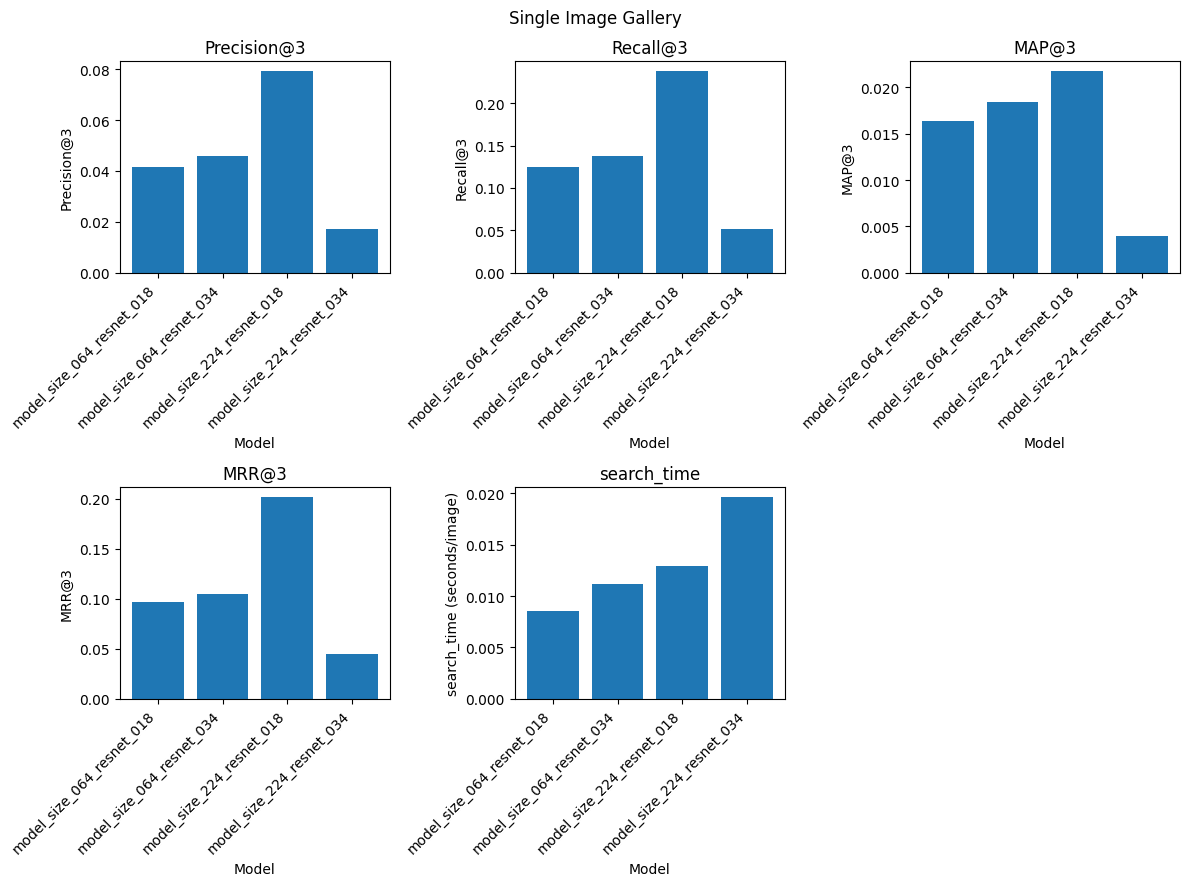

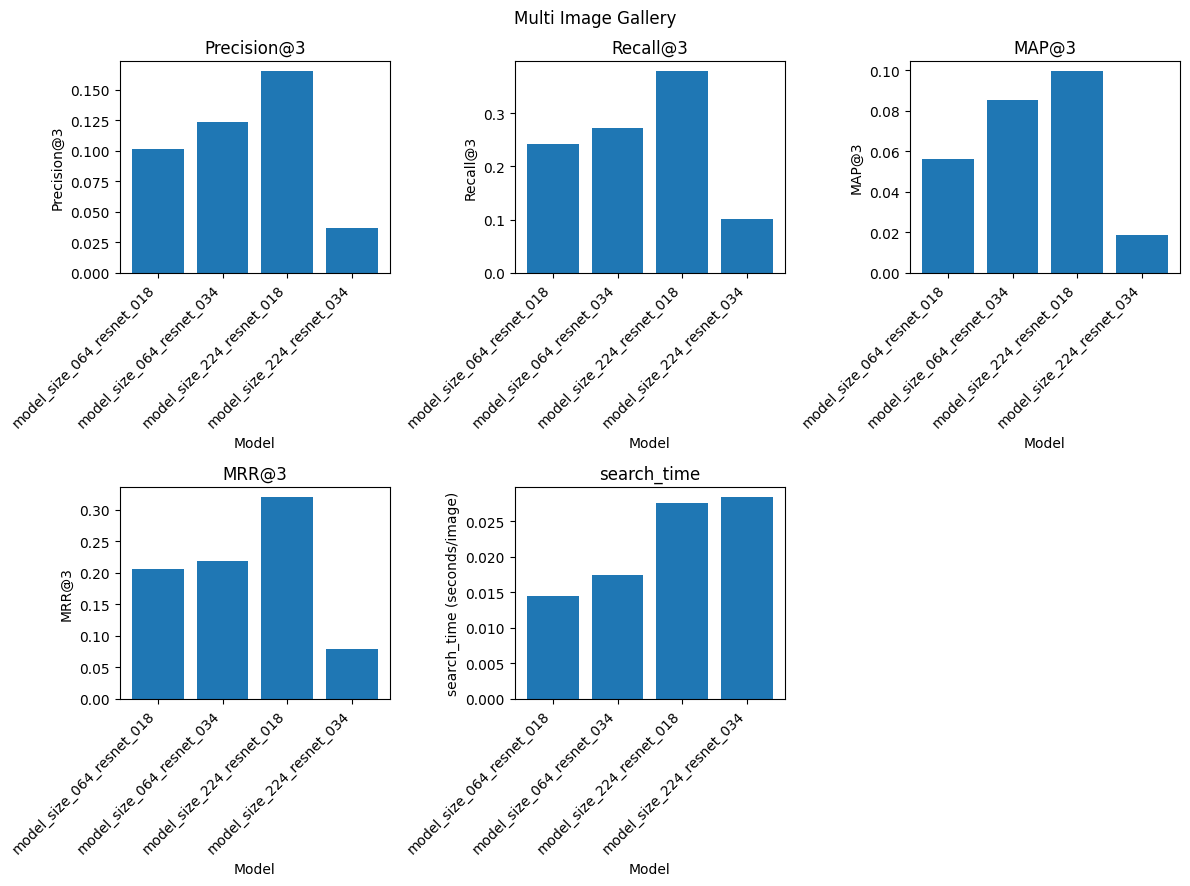

In [80]:
# Calculate model metrics
model_metrics = [{**metrics.calc_metrics(relevance_ranks.get(m)),'search_time': search_times[m]/len(probe_files), 'model': m} for m in models]

# Print model metrics
for m in model_metrics:
    print(f"{m['model']} ({(m['search_time']):.4f} sec/image): {[(k,v) for k,v in m.items() if k not in ['model','search_time']]}")

# Plot results using single and multi image galleries on separate figures
fig1 = plt.figure(figsize=(12,9)) # Single image gallery
fig2 = plt.figure(figsize=(12,9)) # Multi image gallery
spec = mpl.gridspec.GridSpec(ncols=3, nrows=2)
# Create subplot for each metric
subplots = [k for k in model_metrics[0].keys() if k != 'model']
for i in range(len(subplots)):
    s = subplots[i]
    # Get data for the current metric
    bar_names = [mets['model'] for mets in model_metrics if '_multi' not in mets['model']]
    single_vals = [mets[s] for mets in model_metrics if '_multi' not in mets['model']]
    multi_vals = [mets[s] for mets in model_metrics if '_multi' in mets['model']]
    # Plot single and multi image data on separate figures
    ax1 = fig1.add_subplot(spec[i//3, i%3])
    ax2 = fig2.add_subplot(spec[i//3, i%3])
    for ax, vals in zip([ax1, ax2],[single_vals,multi_vals]):
        ax.bar(bar_names, vals)
        ax.set_xticklabels(bar_names,rotation=45, ha='right')
        ax.set_title(s)
        ax.set_xlabel('Model')
        ax.set_ylabel(s if s != 'search_time' else f'{s} (seconds/image)')
# Format figures
fig1.suptitle("Single Image Gallery")
fig2.suptitle("Multi Image Gallery")
fig1.tight_layout()
fig2.tight_layout()
plt.show()

## Additional Analysis
Analysis beyond the minimum two required analyses.

### 3. [Search Service] Similarity Measure

In [72]:
# Initialize metrics object
k = 3
metrics = RankingMetrics(k=k)
# Define list of similarity measyres
def minkowski5(p1, p2): return Measure.minkowski(p1, p2, 5)
def minkowski10(p1, p2): return Measure.minkowski(p1, p2, 10)
measures = [Measure.euclidean, Measure.manhattan, Measure.cosine_similarity, minkowski5, minkowski10]
# Initialize relevance ranks and search times for each measure
relevance_ranks = {m.__name__:[] for m in measures}
search_times = {m.__name__:0 for m in measures}
# Get nearest neighbors for each probe using each similarity measure
for j in range(len(measures)):
    measure = measures[j]
    pipeline_224_018_multi.set_search_measure(measure)
    ranks = []
    for i in range(len(probe_files)):
        probe = Image.open(probe_files[i])
        # Get nearest neighbors
        start = time.time()
        neighbors = pipeline_224_018_multi.search_gallery(probe, k)
        end = time.time()
        search_times[measure.__name__] += (end-start)
        # Determine relevance_rank list based on known probe label
        predicted_names = [f'{n[1]["firstName"]}_{n[1]["lastName"]}' for n in neighbors]
        relevance_rank = [1 if n == true_names[i] else 0 for n in predicted_names]
        ranks.append(relevance_rank)
    relevance_ranks[measure.__name__] = ranks

euclidean (0.0211 sec/image): [('Precision@3', 0.18651985318651987), ('Recall@3', 0.4314314314314314), ('MAP@3', 0.11111111111111109), ('MRR@3', 0.36653319986653315)]
manhattan (0.0227 sec/image): [('Precision@3', 0.18551885218551886), ('Recall@3', 0.42542542542542544), ('MAP@3', 0.1111111111111111), ('MRR@3', 0.363697030363697)]
cosine_similarity (0.0096 sec/image): [('Precision@3', 0.0), ('Recall@3', 0.0), ('MAP@3', 0.0), ('MRR@3', 0.0)]
minkowski5 (0.0311 sec/image): [('Precision@3', 0.18051384718051383), ('Recall@3', 0.4114114114114114), ('MAP@3', 0.11177844511177844), ('MRR@3', 0.34734734734734735)]
minkowski10 (0.0308 sec/image): [('Precision@3', 0.1648314981648315), ('Recall@3', 0.3783783783783784), ('MAP@3', 0.09943276609943275), ('MRR@3', 0.31981981981981983)]


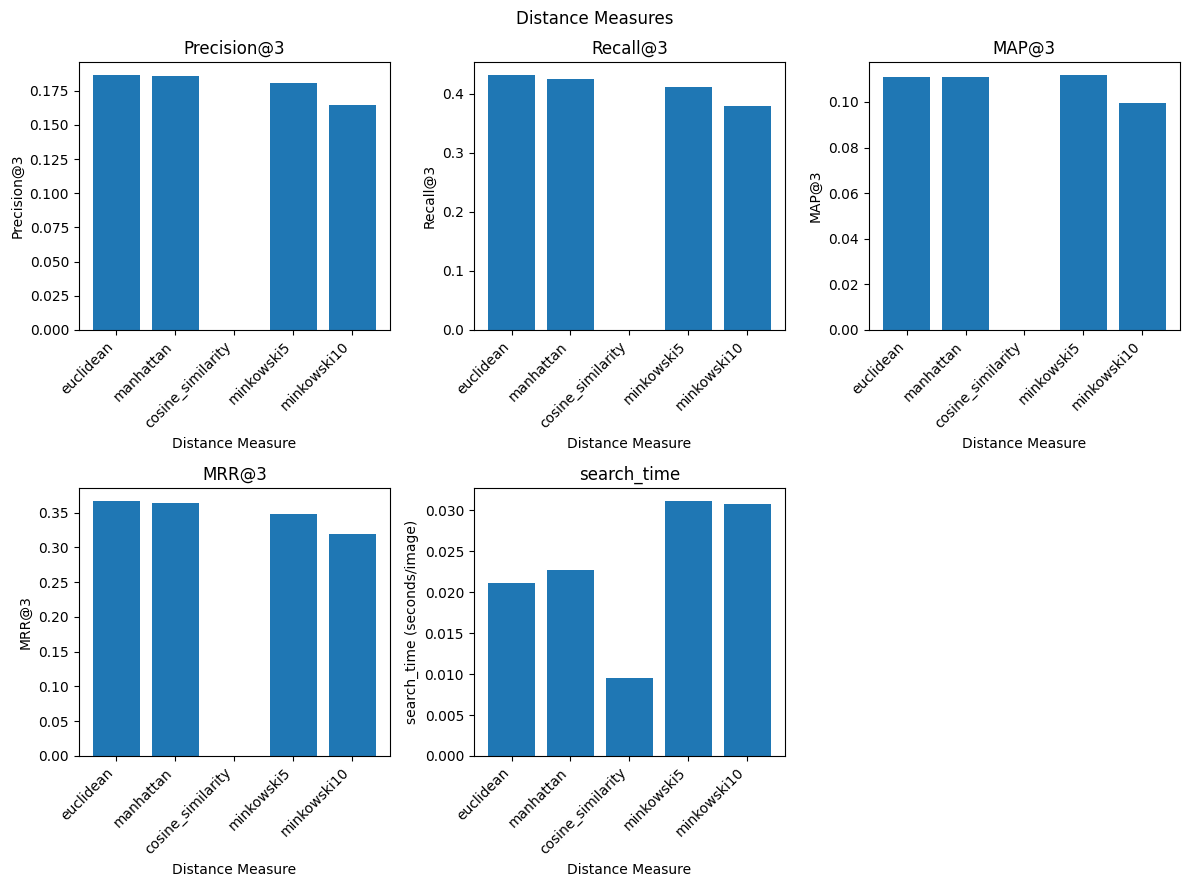

In [78]:
# Calculate measure metrics
measure_metrics = [{**metrics.calc_metrics(relevance_ranks.get(m.__name__)),'search_time': search_times[m.__name__]/len(probe_files), 'measure': m.__name__} for m in measures]

# Print measure metrics
for m in measure_metrics:
    print(f"{m['measure']} ({(m['search_time']):.4f} sec/image): {[(k,v) for k,v in m.items() if k not in ['measure','search_time']]}")

# Plot metrics results in subplots
fig = plt.figure(figsize=(12,9))
spec = mpl.gridspec.GridSpec(ncols=3, nrows=2)
# Create subplot for each metric
subplots = [k for k in measure_metrics[0].keys() if k != 'measure']
for i in range(len(subplots)):
    s = subplots[i]
    # Get data for the current metric
    bar_names = [mets['measure'] for mets in measure_metrics]
    vals = [mets[s] for mets in measure_metrics]
    # Plot data in barchart
    ax = fig.add_subplot(spec[i//3, i%3])
    ax.bar(bar_names, vals)
    ax.set_xticklabels(bar_names,rotation=45, ha='right')
    ax.set_title(s)
    ax.set_xlabel('Distance Measure')
    ax.set_ylabel(s if s != 'search_time' else f'{s} (seconds/image)')
# Format figure
fig.suptitle("Distance Measures")
fig.tight_layout()
plt.show()

### 4. [Search Service] Number of Nearest Neighbors (K) 

In [81]:
ks = [1, 2, 3, 4, 5, 10, 30, 50]
pipeline_224_018_multi.set_search_measure(Measure.euclidean)
relevance_ranks = {k:[] for k in ks}
search_times = {k:0 for k in ks}
for i in range(len(probe_files)):
    probe = Image.open(probe_files[i])
    for k in ks:
        start = time.time()
        neighbors = pipeline_224_018_multi.search_gallery(probe, k)
        end = time.time()
        search_times[k] += (end-start)
        predicted_names = [f'{n[1]["firstName"]}_{n[1]["lastName"]}' for n in neighbors]
        relevance_rank = [1 if n == true_names[i] else 0 for n in predicted_names]
        relevance_ranks.get(k,[]).append(relevance_rank)

k=1 (0.0211 sec/image): [('Precision@1', 0.3163163163163163), ('Recall@1', 0.3163163163163163), ('MAP@1', 0.0), ('MRR@1', 0.3163163163163163)]
k=2 (0.0205 sec/image): [('Precision@2', 0.23123123123123124), ('Recall@2', 0.38738738738738737), ('MAP@2', 0.11061061061061062), ('MRR@2', 0.35185185185185186)]
k=3 (0.0202 sec/image): [('Precision@3', 0.18651985318651987), ('Recall@3', 0.4314314314314314), ('MAP@3', 0.11111111111111109), ('MRR@3', 0.36653319986653315)]
k=4 (0.0205 sec/image): [('Precision@4', 0.16091091091091092), ('Recall@4', 0.45345345345345345), ('MAP@4', 0.11011011011011011), ('MRR@4', 0.37203870537203865)]
k=5 (0.0205 sec/image): [('Precision@5', 0.14274274274274273), ('Recall@5', 0.4774774774774775), ('MAP@5', 0.1037037037037037), ('MRR@5', 0.37684351017684353)]
k=10 (0.0207 sec/image): [('Precision@10', 0.09439439439439438), ('Recall@10', 0.5525525525525525), ('MAP@10', 0.07707707707707707), ('MRR@10', 0.3868765590987814)]
k=30 (0.0209 sec/image): [('Precision@30', 0.04

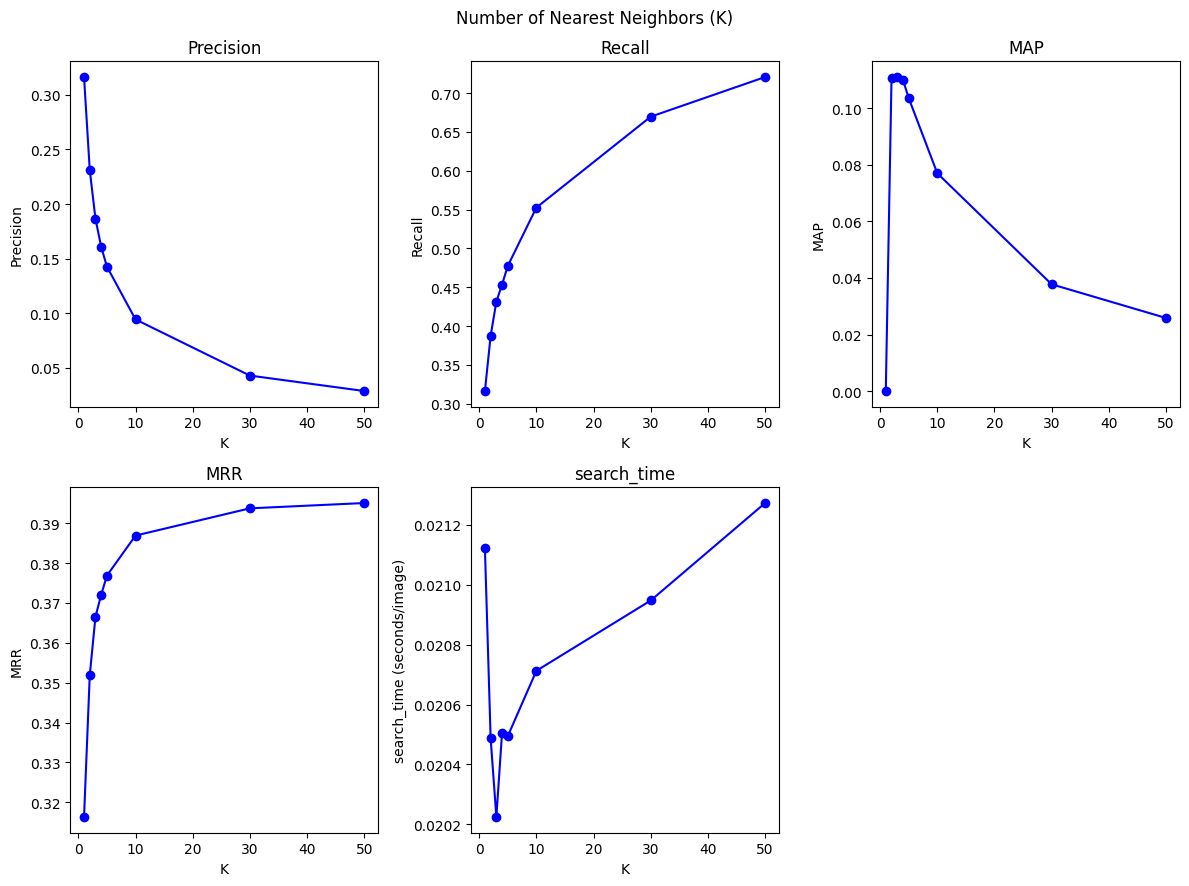

In [95]:
# Calculate and print metrics for each k
k_metrics = []
for k in ks:
    metrics = RankingMetrics(k=k)
    mets = {**metrics.calc_metrics(relevance_ranks.get(k)),'search_time': search_times[k]/len(probe_files), 'k': k}
    k_metrics.append(mets)
    print(f"k={mets['k']} ({(mets['search_time']):.4f} sec/image): {[(key,val) for key,val in mets.items() if key not in ['k','search_time']]}")

# Plot metrics results in subplots
fig = plt.figure(figsize=(12,9))
spec = mpl.gridspec.GridSpec(ncols=3, nrows=2)
# Create subplot for each metric
subplots = [key for key in k_metrics[0].keys() if key != 'k']
for i in range(len(subplots)):
    s = subplots[i].split('@')[0]
    # Get data for the current metric
    kk = [mets['k'] for mets in k_metrics]
    vals = [mets[s if s == 'search_time' else f"{s}@{mets['k']}"] for mets in k_metrics]
    # Plot data in barchart
    ax = fig.add_subplot(spec[i//3, i%3])
    ax.plot(kk, vals,'bo-')
    ax.set_title(s)
    ax.set_xlabel('K')
    ax.set_ylabel(s if s != 'search_time' else f'{s} (seconds/image)')
# Format figure
fig.suptitle("Number of Nearest Neighbors (K)")
fig.tight_layout()
plt.show()